CRF sequence tagging for Movie Queries

In [1]:
#############  The classification reports are shown at the bottom of the notebook ##########

import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [2]:
def get_raw_data_from_bio_file(fpath):
   
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
#Splits the train data

trainSplit = 1                   # Percentage of the split(Change to 1 when testing on real test set)

raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt")   # Retrieving data from engtrain.bio.txt
split = int(len(raw_training_data)*trainSplit)   # Calculating for the split in integer for any size of dataset

train_data = raw_training_data[0:split]         # 80% of training set
validation_data = raw_training_data[split:]     # 20% of dev set





print("Length of raw_training_data:",len(raw_training_data))    
print("Length of train_data:",len(train_data))
print("Length of train_data:",len(validation_data))

Length of raw_training_data: 9775
Length of train_data: 9775
Length of train_data: 0


In [4]:
# have a look at the first example
print(train_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [5]:
print(len(train_data), "instances")
print(sum([len(sent) for sent in train_data]), "words")

9775 instances
99491 words


In [6]:
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

def preProcess(dataset):
     
    words = [i[0] for i in dataset]                           #Extract the 1st element (words) of the dataset
    
    bio = [i[1] for i in dataset]                             #Extract the 2nd element (BIOtag) of the dataset
   
    tagged = posttagger.tag(words)                             #Feed the words into the postagger
    
    tags = [s[1] for s in tagged]                              #Extracts the postags for each word
   
    joined = ["@" + j for j in tags]                           #Add special charater in front of each postags
   
    jointag = [(x+y) for x, y in zip([i[0] for i in dataset], joined )] #Combines the postags to the words
    
    final = [(x,y) for x, y in zip(jointag, bio )]             #Place the biotag strings back in the list corresponding the each words
   
    preprocessed_example = final 
    return preprocessed_example

In [7]:
training_data = [preProcess(example) for example in train_data]

In [8]:
# check the effect of pre-processing
print(training_data[7])

[('do@VBP', 'O'), ('you@PRP', 'O'), ('have@VBP', 'O'), ('any@DT', 'O'), ('thrillers@NNS', 'B-GENRE'), ('directed@VBN', 'O'), ('by@IN', 'O'), ('sofia@NNP', 'B-DIRECTOR'), ('coppola@NNP', 'I-DIRECTOR')]


In [9]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
   
    
    feature_list = []                       #Empty feature list
    token = tokens[idx].split("@")[0]       #Splits the string at the @ symbol and extract the first element (the word)
   
    if not token:                 #If it receives an empty token, returns nothing to list
        return feature_list
    
    #Split tokens at @              #Spliting string to extract postags
    if "@" in token:                #Identifies if the string have @ symbol  
        pos = tokens.split("@")     #Splits the string at the symbol
        pos = pos[1]                #Assigns the 2nd element of string to object 'pos'
        feature_list.append("POS_" + pos)      #Appends "POS_[postag]" to the feature_list
        feature_list.append(pos+"_"+token)     #Appends "[postag]_[WORD]" to feature_list
         
    # Capitalization
    if token[0].isupper():          #Checks for capitalisation 
        feature_list.append("CAPITALIZATION")  #appends "CAPITALIZATION" to feature_list if it is present

    # Number
    if re.search(_pattern, token) is not None:  #Checks for digits
        feature_list.append("HAS_NUM")         #appends "HAS_NUM" to feature_list if it is present

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])   #Punctuation types
    if all(unicodedata.category(x) in punc_cat for x in token):  #Checks for punctuation 
        feature_list.append("PUNCTUATION")                       #appends "PUNCTUATION" to feature_list if it is present

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])  #appends suffix(last letter) to feature_list 
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])  #appends suffix(last 2 letters) to feature_list 
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])  #appends suffix(last 3 letters) to feature_list
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])  #appends suffix(last 4 letters) to feature_list
    if len(token) > 5:
        feature_list.append("SUF_" + token[-5:])  #appends suffix(last 5 letters) to feature_list
    
    # Prefix up to length 4
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])  #appends prefix(first letter) to feature_list

    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])  #appends prefix(first 2 letters) to feature_list    
        
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])  #appends prefix(first 3 letters) to feature_list
        
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4]) #appends prefix(first 4 letters) to feature_list
        
    if len(token) > 5:
        feature_list.append("PRE_" + token[:5])  #appends prefix(first 5 letters) to feature_list
        
    #Windowing    
    if token[-1] is not None:
        feature_list.append(token[-1] + token)   #appends the previous token and current token to feature_list
    if len(token) > 2:    
        if token[-2] is not None:
            feature_list.append(token[-2] + token[-1] + token)   #appends 2 previous tokens and current token to feature_list

        
    feature_list.append("WORD_" + token)         #appends the word to feature_list
    
    
    return feature_list   


In [10]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [11]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)   # initialize tagger
ct.set_model_file(TAGGER_PATH)              # load model from file
# test_data = validation_data                 #For Q1 to Q4, the test_data is the validation set (comment out to test on real test set)

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt")   #uncomment to test on real test set
test_data = [preProcess(example) for example in raw_test_data]  #uncomment to test on real test set

print(len(test_data), "instances") #validation set was split above
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [12]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [13]:
#Lowest Presicion
lowPre1 = "I-TRAILER"
lowPre2 = "I-REVIEW"
lowPre3 = "I=PLOT"
lowPre4 = "I-SONG"
lowPre5 = "B-PLOT"

#Filters out sentences for which its BIO tag prediction is not in ground truth (presicion)
#in order of the lowest precision to the fifth lowest


print("testing tagger...")
print("Bottom 5 Precision")
preds = []
y_test = []
for sent in test_data:                                            #loops through the test_data
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]     #Extracts the predicted tag into sent_preds
    sent_true = [s[1] for s in sent]                              #Extracts the ground truth tag into sent_true
    if sent_preds != sent_true:                                   #Filters out all the instances where its predicted tag is not in ground truth
        if lowPre1 in sent_preds:                                 #Compares if tag is in predicted instances
            if lowPre1 not in sent_true:                          #If it is predicted and not in ground truth
                print("Predicted Class:",lowPre1,"\n",ct.tag([s[0] for s in sent])) #Print the sentence that predicts the tag
                print("Ground Truth:\n",sent_true,"\n")                        #Prints the ground truth tags
                
for sent in test_data:                                            #The rest of the for loops repeats the same process above,
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]     #but for other tags to obtain output in order of lowest precision
    sent_true = [s[1] for s in sent]                              #to the fifth lowest
    if sent_preds != sent_true:                
        if lowPre2 in sent_preds:
            if lowPre2 not in sent_true:
                print("Predicted Class:",lowPre2,"\n",ct.tag([s[0] for s in sent]))
                print("Ground Truth:\n",sent_true,"\n")
    
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    if sent_preds != sent_true:               
        if lowPre3 in sent_preds:
            if lowPre3 not in sent_true:
                print("Predicted Class:",lowPre3,"\n",ct.tag([s[0] for s in sent]))
                print("Ground Truth:\n",sent_true,"\n")
                
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    if sent_preds != sent_true:                
        if lowPre4 in sent_preds:
            if lowPre4 not in sent_true:
                print("Predicted Class:",lowPre4,"\n",ct.tag([s[0] for s in sent]))
                print("Ground Truth:\n",sent_true,"\n")
                
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    if sent_preds != sent_true:                
        if lowPre5 in sent_preds:
            if lowPre5 not in sent_true:
                print("Predicted Class:",lowPre5,"\n",ct.tag([s[0] for s in sent]))
                print("Ground Truth:\n",sent_true,"\n")
                
    preds.extend(sent_preds)  #predicted tag is added to the preds list
    y_test.extend(sent_true)  #ground truth tag is added to y_test list for the output classification report
print("done")

testing tagger...
Bottom 5 Precision
Predicted Class: I-REVIEW 
 [('show@VB', 'O'), ('me@PRP', 'O'), ('movies@NNS', 'O'), ('with@IN', 'O'), ('oscar@NNP', 'B-REVIEW'), ('winning@NNP', 'I-REVIEW'), ('actors@NNPS', 'I-REVIEW')]
Ground Truth:
 ['O', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'I-ACTOR'] 

Predicted Class: I-REVIEW 
 [('what@WP', 'O'), ('is@VBZ', 'O'), ('the@DT', 'O'), ('most@RBS', 'B-REVIEW'), ('positively@RB', 'I-REVIEW'), ('reviewed@JJ', 'I-REVIEW'), ('romance@NN', 'B-GENRE'), ('movie@NN', 'O')]
Ground Truth:
 ['O', 'O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'B-GENRE', 'O'] 

Predicted Class: I-REVIEW 
 [('what@WP', 'O'), ('m@NNP', 'B-DIRECTOR'), ('night@NN', 'I-DIRECTOR'), ('shyamalan@NN', 'I-DIRECTOR'), ('movie@NN', 'O'), ('got@VBD', 'O'), ('the@DT', 'O'), ('best@JJS', 'B-REVIEW'), ('reviews@NNS', 'I-REVIEW')]
Ground Truth:
 ['O', 'B-DIRECTOR', 'I-DIRECTOR', 'I-DIRECTOR', 'O', 'O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE'] 

Predicted Class:

Predicted Class: B-PLOT 
 [('what@WP', 'O'), ('critically@RB', 'B-RATINGS_AVERAGE'), ('acclaimed@JJ', 'I-RATINGS_AVERAGE'), ('movies@NNS', 'O'), ('starred@VBD', 'O'), ('ben@NNP', 'B-ACTOR'), ('stiller@NNP', 'I-ACTOR'), ('or@CC', 'O'), ('his@PRP$', 'O'), ('parents@NNS', 'B-PLOT'), ('in@IN', 'O'), ('the@DT', 'O'), ('last@JJ', 'B-YEAR'), ('five@CD', 'I-YEAR'), ('decades@NNS', 'I-YEAR')]
Ground Truth:
 ['O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'O', 'O', 'O', 'O', 'B-YEAR', 'I-YEAR', 'I-YEAR'] 

Predicted Class: B-PLOT 
 [('what@WP', 'O'), ('is@VBZ', 'O'), ('annihilation@NN', 'B-PLOT'), ('earth@NN', 'I-PLOT'), ('about@IN', 'O')]
Ground Truth:
 ['O', 'O', 'B-TITLE', 'I-TITLE', 'O'] 

Predicted Class: B-PLOT 
 [('what@WP', 'O'), ('is@VBZ', 'O'), ('the@DT', 'O'), ('governess@NN', 'B-PLOT'), ('about@IN', 'O')]
Ground Truth:
 ['O', 'O', 'B-TITLE', 'I-TITLE', 'O'] 

Predicted Class: B-PLOT 
 [('what@WP', 'O'), ('is@VBZ', 'O'), ('a@DT', 'O'), ('must@MD', 

In [14]:
#Lowest Recall

lowRe1 = "I-TRAILER"
lowRe2 = "I-REVIEW"
lowRe3 = "I=SONG"
lowRe4 = "B-SONG"
lowRe5 = "B-CHARACTER"

#Filters out sentences for which its BIO tag prediction is not in ground truth (presicion)
#in order of the lowest precision to the fifth lowest


print("Bottom 5 Recall:")

for sent in test_data:                                            #loops through the test_data
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]     #Extracts the predicted tag into sent_preds
    sent_true = [s[1] for s in sent]                              #Extracts the ground truth tag into sent_true
    if sent_true != sent_preds:                                   #Filters out all the instances where its groundtruth tag is not in predicted
        if lowRe1 in sent_true:                                   #Compares if tag is in true tag lists
            if lowRe1 not in sent_preds:                          #If it is present and not predicted
                print("Ground Truth Class:",lowRe1,"\n",sent_true)    #Print the sentence that predicts the tag
                print("Predicited:\n",ct.tag([s[0] for s in sent]),"\n")    #Prints the ground truth tags
                
for sent in test_data:                                            
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]    
    sent_true = [s[1] for s in sent]                             
    if sent_true != sent_preds:                                  
        if lowRe2 in sent_true:                                 
            if lowRe2 not in sent_preds:                        
                print("Ground Truth Class:",lowRe2,"\n",sent_true)                
                print("Predicited:\n",ct.tag([s[0] for s in sent]),"\n") 
                
for sent in test_data:                                            
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]    
    sent_true = [s[1] for s in sent]                             
    if sent_true != sent_preds:                                  
        if lowRe3 in sent_true:                                 
            if lowRe3 not in sent_preds:                        
                print("Ground Truth Class:",lowRe3,"\n",sent_true)                
                print("Predicited:\n",ct.tag([s[0] for s in sent]),"\n") 
                
for sent in test_data:                                            
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]    
    sent_true = [s[1] for s in sent]                             
    if sent_true != sent_preds:                                  
        if lowRe4 in sent_true:                                 
            if lowRe4 not in sent_preds:                        
                print("Ground Truth Class:",lowRe4,"\n",sent_true)                
                print("Predicited:\n",ct.tag([s[0] for s in sent]),"\n") 
                
for sent in test_data:                                            
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]    
    sent_true = [s[1] for s in sent]                             
    if sent_true != sent_preds:                                  
        if lowRe5 in sent_true:                                 
            if lowRe5 not in sent_preds:                        
                print("Ground Truth Class:",lowRe5,"\n",sent_true)                
                print("Predicited:\n",ct.tag([s[0] for s in sent]),"\n") 

Bottom 5 Recall:
Ground Truth Class: I-TRAILER 
 ['O', 'O', 'O', 'B-TRAILER', 'I-TRAILER', 'I-TRAILER']
Predicited:
 [('what@WP', 'O'), ('is@VBZ', 'O'), ('the@DT', 'O'), ('best@JJS', 'O'), ('movie@NN', 'O'), ('trailer@NN', 'B-TRAILER')] 

Ground Truth Class: I-TRAILER 
 ['B-TRAILER', 'I-TRAILER', 'I-TRAILER', 'I-TRAILER', 'I-TRAILER', 'I-TRAILER', 'I-TRAILER']
Predicited:
 [('find@VB', 'O'), ('a@DT', 'O'), ('trailer@NN', 'B-TRAILER'), ('for@IN', 'O'), ('chariots@NNS', 'B-TITLE'), ('of@IN', 'I-TITLE'), ('fire@NN', 'I-TITLE')] 

Ground Truth Class: I-REVIEW 
 ['O', 'O', 'O', 'O', 'B-REVIEW', 'I-REVIEW', 'O', 'O', 'B-RATINGS_AVERAGE', 'O', 'O', 'B-DIRECTOR', 'I-DIRECTOR']
Predicited:
 [('may@MD', 'O'), ('i@PRP', 'O'), ('have@VBP', 'O'), ('the@DT', 'O'), ('highly@RB', 'B-RATINGS_AVERAGE'), ('acclaimed@JJ', 'I-RATINGS_AVERAGE'), ('film@NN', 'O'), ('from@IN', 'O'), ('1985@NNP', 'B-YEAR'), ('directed@NNP', 'O'), ('by@NNP', 'O'), ('sylvester@NNP', 'B-ACTOR'), ('stallone@NNP', 'I-ACTOR')] 

Gro

Ground Truth Class: B-CHARACTER 
 ['B-CHARACTER']
Predicited:
 [('todd@JJ', 'O')] 

Ground Truth Class: B-CHARACTER 
 ['O', 'O', 'O', 'O', 'O', 'B-CHARACTER', 'I-CHARACTER']
Predicited:
 [('what@WP', 'O'), ('was@VBD', 'O'), ('the@DT', 'O'), ('film@NN', 'O'), ('about@IN', 'O'), ('brandon@NNP', 'B-ACTOR'), ('teena@NNP', 'I-ACTOR')] 

Ground Truth Class: B-CHARACTER 
 ['B-CHARACTER', 'I-CHARACTER']
Predicited:
 [('super@JJR', 'B-TITLE'), ('man@NN', 'I-TITLE')] 

Ground Truth Class: B-CHARACTER 
 ['O', 'O', 'B-CHARACTER', 'I-CHARACTER', 'O', 'B-TITLE', 'I-TITLE']
Predicited:
 [('who@WP', 'O'), ('played@VBD', 'O'), ('dwight@VBN', 'B-DIRECTOR'), ('mccarthy@JJ', 'I-DIRECTOR'), ('in@IN', 'O'), ('sin@NNP', 'B-TITLE'), ('city@NNP', 'I-TITLE')] 

Ground Truth Class: B-CHARACTER 
 ['O', 'O', 'O', 'O', 'O', 'B-CHARACTER', 'I-CHARACTER', 'O', 'B-TITLE', 'I-TITLE', 'I-TITLE']
Predicited:
 [('what@WP', 'O'), ('was@VBD', 'O'), ('the@DT', 'O'), ('name@NN', 'O'), ('of@IN', 'O'), ('ariels@NNS', 'B-TITLE')

In [15]:
# Output the classification report (which you should save each time for comparing your models)
classReport= classification_report(y_test, preds)
print(classReport)

C:\Users\FiercePC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.80      0.91      0.85       812
      B-CHARACTER       0.67      0.33      0.44        90
       B-DIRECTOR       0.82      0.66      0.73       456
          B-GENRE       0.92      0.96      0.94      1117
           B-PLOT       0.65      0.57      0.61       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.88      0.84      0.86       451
         B-REVIEW       0.20      0.02      0.03        56
           B-SONG       0.61      0.26      0.36        54
          B-TITLE       0.64      0.57      0.60       562
        B-TRAILER       0.78      0.83      0.81        30
           B-YEAR       0.95      0.95      0.95       720
          I-ACTOR       0.80      0.91      0.85       862
      I-CHARACTER       0.67      0.32      0.43        75
       I-DIRECTOR       0.82      0.65      0.72       496
          I-GENRE       0.87      0.70      0.78       

In [16]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

C:\Users\FiercePC\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['I-REVIEW', 'I-DIRECTOR', 'B-REVIEW', 'B-TITLE', 'O', 'B-ACTOR', 'B-PLOT', 'B-RATING', 'I-SONG', 'B-GENRE', 'B-YEAR', 'I-TRAILER', 'I-YEAR', 'I-GENRE', 'I-ACTOR', 'I-RATING', 'B-DIRECTOR', 'I-PLOT', 'B-SONG', 'I-TITLE', 'B-CHARACTER', 'I-RATINGS_AVERAGE', 'B-TRAILER', 'B-RATINGS_AVERAGE', 'I-CHARACTER'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


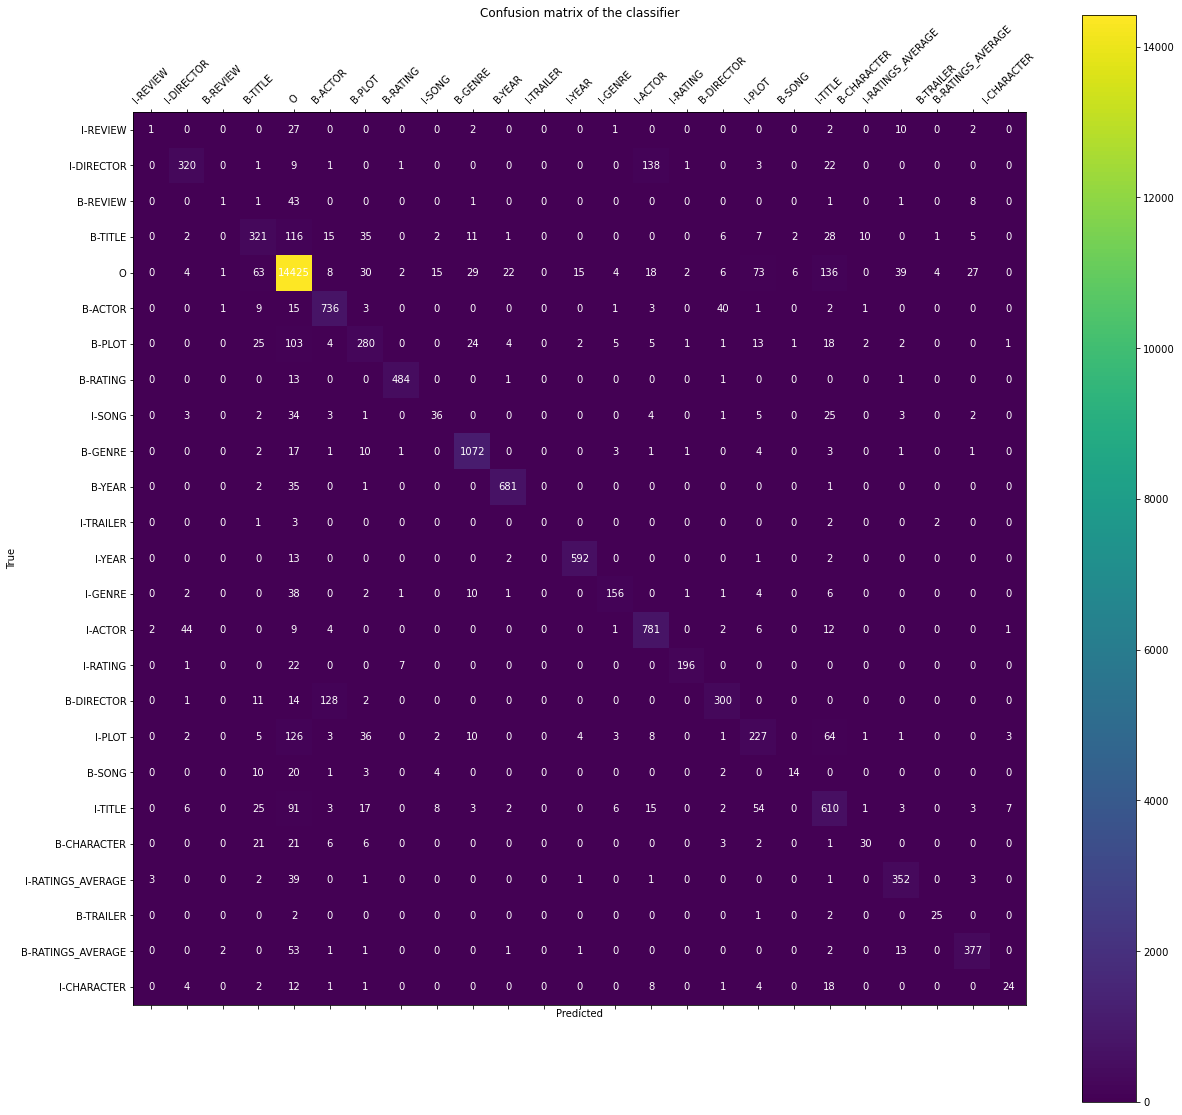

In [17]:
confusion_matrix_heatmap(y_test, preds)

# Results

# Q1

In [ ]:
#                #####  Results using 80/20 dev test set  ######

#                    precision    recall  f1-score   support

#           B-ACTOR       0.65      0.87      0.74       433
#       B-CHARACTER       0.70      0.32      0.44        44
#        B-DIRECTOR       0.76      0.63      0.69       365
#           B-GENRE       0.96      0.97      0.97       927
#            B-PLOT       0.48      0.43      0.45       298
#          B-RATING       1.00      1.00      1.00       430
# B-RATINGS_AVERAGE       0.88      0.88      0.88       451
#          B-REVIEW       0.00      0.00      0.00        31
#            B-SONG       0.50      0.25      0.33        20
#           B-TITLE       0.66      0.35      0.46       679
#         B-TRAILER       1.00      0.50      0.67        28
#            B-YEAR       0.89      1.00      0.94       535
#           I-ACTOR       0.66      0.85      0.74       482
#       I-CHARACTER       0.58      0.60      0.59        47
#        I-DIRECTOR       0.76      0.62      0.69       410
#           I-GENRE       0.90      1.00      0.95       123
#            I-PLOT       0.28      0.64      0.39       148
#          I-RATING       0.98      1.00      0.99       156
# I-RATINGS_AVERAGE       0.76      0.94      0.84       408
#          I-REVIEW       0.00      0.00      0.00         9
#            I-SONG       0.29      0.23      0.26        43
#           I-TITLE       0.75      0.48      0.58      1182
#         I-TRAILER       0.00      0.00      0.00         1
#            I-YEAR       0.95      1.00      0.98       528
#                 O       0.94      0.96      0.95     12447

#          accuracy                           0.88     20225
#         macro avg       0.65      0.62      0.62     20225
#      weighted avg       0.88      0.88      0.87     20225

# Q4

In [ ]:
            #Result after adding postags in feature_list

#                    precision    recall  f1-score   support

#           B-ACTOR       0.65      0.87      0.74       433
#       B-CHARACTER       0.70      0.32      0.44        44
#        B-DIRECTOR       0.76      0.63      0.69       365
#           B-GENRE       0.96      0.97      0.97       927
#            B-PLOT       0.48      0.43      0.45       298
#          B-RATING       1.00      1.00      1.00       430
# B-RATINGS_AVERAGE       0.88      0.88      0.88       451
#          B-REVIEW       0.00      0.00      0.00        31
#            B-SONG       0.50      0.25      0.33        20
#           B-TITLE       0.66      0.35      0.46       679
#         B-TRAILER       1.00      0.50      0.67        28
#            B-YEAR       0.89      1.00      0.94       535
#           I-ACTOR       0.66      0.85      0.74       482
#       I-CHARACTER       0.58      0.60      0.59        47
#        I-DIRECTOR       0.76      0.62      0.69       410
#           I-GENRE       0.90      1.00      0.95       123
#            I-PLOT       0.28      0.64      0.39       148
#          I-RATING       0.98      1.00      0.99       156
# I-RATINGS_AVERAGE       0.76      0.94      0.84       408
#          I-REVIEW       0.00      0.00      0.00         9
#            I-SONG       0.29      0.23      0.26        43
#           I-TITLE       0.75      0.48      0.58      1182
#         I-TRAILER       0.00      0.00      0.00         1
#            I-YEAR       0.95      1.00      0.98       528
#                 O       0.94      0.96      0.95     12447

#          accuracy                           0.88     20225
#         macro avg       0.65      0.62      0.62     20225
#      weighted avg       0.88      0.88      0.87     20225

## COMMENTS
# The macro avg of the classifier remained the same after the postags been added the the feature list.
#Which is odd, I was expecting for it to have some effect to the result. In this case it didn't

# Q5

In [ ]:
###         Added suffix (last 5 letters) of the word
###         test set = dev set

#         precision    recall  f1-score   support

#           B-ACTOR       0.68      0.87      0.76       433
#       B-CHARACTER       0.65      0.30      0.41        44
#        B-DIRECTOR       0.75      0.63      0.69       365
#           B-GENRE       0.96      0.98      0.97       927
#            B-PLOT       0.51      0.51      0.51       298
#          B-RATING       1.00      1.00      1.00       430
# B-RATINGS_AVERAGE       0.88      0.89      0.88       451
#          B-REVIEW       0.00      0.00      0.00        31
#            B-SONG       0.46      0.30      0.36        20
#           B-TITLE       0.67      0.35      0.46       679
#         B-TRAILER       1.00      0.50      0.67        28
#            B-YEAR       0.89      1.00      0.94       535
#           I-ACTOR       0.69      0.85      0.76       482
#       I-CHARACTER       0.56      0.57      0.57        47
#        I-DIRECTOR       0.75      0.62      0.68       410
#           I-GENRE       0.92      1.00      0.96       123
#            I-PLOT       0.28      0.68      0.39       148
#          I-RATING       0.98      1.00      0.99       156
# I-RATINGS_AVERAGE       0.77      0.94      0.85       408
#          I-REVIEW       0.00      0.00      0.00         9
#            I-SONG       0.28      0.30      0.29        43
#           I-TITLE       0.78      0.48      0.59      1182
#         I-TRAILER       0.00      0.00      0.00         1
#            I-YEAR       0.96      1.00      0.98       528
#                 O       0.94      0.96      0.95     12447

#          accuracy                           0.88     20225
#         macro avg       0.65      0.63      0.63     20225
#      weighted avg       0.88      0.88      0.88     20225

## COMMENTS
## After adding another suffix feature to take the last 5 letters of the word,
## the macro avg increased to 0.63


###         Added prefix (first 5 letters) of the word
###         test set = dev set

#                    precision    recall  f1-score   support

#           B-ACTOR       0.70      0.88      0.78       433
#       B-CHARACTER       0.58      0.25      0.35        44
#        B-DIRECTOR       0.78      0.65      0.71       365
#           B-GENRE       0.97      0.98      0.98       927
#            B-PLOT       0.61      0.64      0.62       298
#          B-RATING       1.00      1.00      1.00       430
# B-RATINGS_AVERAGE       0.90      0.90      0.90       451
#          B-REVIEW       0.00      0.00      0.00        31
#            B-SONG       0.32      0.35      0.33        20
#           B-TITLE       0.68      0.39      0.50       679
#         B-TRAILER       0.94      0.54      0.68        28
#            B-YEAR       0.96      1.00      0.98       535
#           I-ACTOR       0.70      0.87      0.78       482
#       I-CHARACTER       0.56      0.40      0.47        47
#        I-DIRECTOR       0.77      0.65      0.70       410
#           I-GENRE       0.92      1.00      0.96       123
#            I-PLOT       0.36      0.77      0.49       148
#          I-RATING       0.99      1.00      0.99       156
# I-RATINGS_AVERAGE       0.79      0.94      0.86       408
#          I-REVIEW       0.00      0.00      0.00         9
#            I-SONG       0.27      0.40      0.32        43
#           I-TITLE       0.80      0.53      0.63      1182
#         I-TRAILER       0.00      0.00      0.00         1
#            I-YEAR       0.96      1.00      0.98       528
#                 O       0.95      0.97      0.96     12447

#          accuracy                           0.89     20225
#         macro avg       0.66      0.64      0.64     20225
#      weighted avg       0.89      0.89      0.89     20225

## COMMENTS
## By adding prefix to the feature list the macro avg increased to 0.64
## I also tested the prefix to take the first 5 letters for words like "extraordinary", the result remained at 0.64


###         Added windowing for previous token and 2 previous token
###         test set = dev set

#                    precision    recall  f1-score   support

#           B-ACTOR       0.68      0.88      0.77       433
#       B-CHARACTER       0.67      0.32      0.43        44
#        B-DIRECTOR       0.77      0.64      0.70       365
#           B-GENRE       0.97      0.98      0.97       927
#            B-PLOT       0.54      0.55      0.54       298
#          B-RATING       0.99      1.00      1.00       430
# B-RATINGS_AVERAGE       0.89      0.90      0.89       451
#          B-REVIEW       0.00      0.00      0.00        31
#            B-SONG       0.39      0.35      0.37        20
#           B-TITLE       0.70      0.37      0.49       679
#         B-TRAILER       1.00      0.54      0.70        28
#            B-YEAR       0.89      1.00      0.94       535
#           I-ACTOR       0.69      0.86      0.77       482
#       I-CHARACTER       0.57      0.60      0.58        47
#        I-DIRECTOR       0.77      0.63      0.70       410
#           I-GENRE       0.93      1.00      0.96       123
#            I-PLOT       0.30      0.74      0.43       148
#          I-RATING       0.97      1.00      0.99       156
# I-RATINGS_AVERAGE       0.77      0.94      0.85       408
#          I-REVIEW       0.00      0.00      0.00         9
#            I-SONG       0.32      0.35      0.33        43
#           I-TITLE       0.80      0.50      0.62      1182
#         I-TRAILER       0.00      0.00      0.00         1
#            I-YEAR       0.96      1.00      0.98       528
#                 O       0.95      0.96      0.95     12447

#          accuracy                           0.89     20225
#         macro avg       0.66      0.64      0.64     20225
#      weighted avg       0.89      0.89      0.88     20225

## COMMENTS
## By adding windowing to the feature list the macro avg increased to 0.64

###      Combining best features(postags, suffix[-5], prefix[5] and windowing)
###      test set = dev set

#                    precision    recall  f1-score   support

#           B-ACTOR       0.71      0.88      0.79       433
#       B-CHARACTER       0.62      0.34      0.44        44
#        B-DIRECTOR       0.78      0.67      0.72       365
#           B-GENRE       0.97      0.99      0.98       927
#            B-PLOT       0.62      0.67      0.64       298
#          B-RATING       0.99      1.00      1.00       430
# B-RATINGS_AVERAGE       0.88      0.90      0.89       451
#          B-REVIEW       0.00      0.00      0.00        31
#            B-SONG       0.28      0.35      0.31        20
#           B-TITLE       0.69      0.40      0.51       679
#         B-TRAILER       0.94      0.54      0.68        28
#            B-YEAR       0.96      1.00      0.98       535
#           I-ACTOR       0.71      0.87      0.78       482
#       I-CHARACTER       0.54      0.60      0.57        47
#        I-DIRECTOR       0.77      0.66      0.71       410
#           I-GENRE       0.92      1.00      0.96       123
#            I-PLOT       0.37      0.78      0.50       148
#          I-RATING       0.98      1.00      0.99       156
# I-RATINGS_AVERAGE       0.78      0.95      0.86       408
#          I-REVIEW       0.00      0.00      0.00         9
#            I-SONG       0.24      0.40      0.30        43
#           I-TITLE       0.83      0.54      0.65      1182
#         I-TRAILER       0.00      0.00      0.00         1
#            I-YEAR       0.97      1.00      0.98       528
#                 O       0.95      0.97      0.96     12447

#          accuracy                           0.90     20225
#         macro avg       0.66      0.66      0.65     20225
#      weighted avg       0.90      0.90      0.89     20225

## COMMENTS
## By combining all the best features, the best macro avg result obtained is 0.65


###      Combining all best features 
###      test set = "engtest.bio.txt"

#                    precision    recall  f1-score   support

#           B-ACTOR       0.80      0.90      0.85       812
#       B-CHARACTER       0.67      0.33      0.44        90
#        B-DIRECTOR       0.82      0.65      0.72       456
#           B-GENRE       0.92      0.96      0.94      1117
#            B-PLOT       0.64      0.56      0.60       491
#          B-RATING       0.98      0.97      0.97       500
# B-RATINGS_AVERAGE       0.88      0.84      0.86       451
#          B-REVIEW       0.17      0.02      0.03        56
#            B-SONG       0.60      0.22      0.32        54
#           B-TITLE       0.64      0.57      0.60       562
#         B-TRAILER       0.78      0.83      0.81        30
#            B-YEAR       0.95      0.95      0.95       720
#           I-ACTOR       0.79      0.90      0.84       862
#       I-CHARACTER       0.67      0.32      0.43        75
#        I-DIRECTOR       0.82      0.64      0.72       496
#           I-GENRE       0.86      0.70      0.77       222
#            I-PLOT       0.56      0.46      0.50       496
#          I-RATING       0.97      0.87      0.92       226
# I-RATINGS_AVERAGE       0.83      0.87      0.85       403
#          I-REVIEW       0.17      0.02      0.04        45
#            I-SONG       0.52      0.27      0.36       119
#           I-TITLE       0.63      0.71      0.67       856
#         I-TRAILER       0.00      0.00      0.00         8
#            I-YEAR       0.97      0.97      0.97       610
#                 O       0.94      0.97      0.95     14929

#          accuracy                           0.89     24686
#         macro avg       0.70      0.62      0.64     24686
#      weighted avg       0.88      0.89      0.89     24686

## COMMENTS
## After training on all training data and tested on unseen engtest.bio.txt test set,
## the final macro avg f1 score achieved is 0.65